## EDA 결론 및 이탈(비구매) 인사이트 요약

1. **데이터 품질**
   - 타깃(`Revenue`)은 약 15%가 구매, 85%가 비구매로 클래스 불균형(약 5.5:1)이 존재한다.

2. **이탈과 가장 관련이 깊은 행동 특성**
   - `PageValues`는 구매 여부와 가장 강한 양의 상관을 보이며, 0인 세션은 대부분 비구매로 끝난다.
   - `BounceRates`와 `ExitRates`는 전환과 음의 상관을 보이며, 값이 높을수록 구매율이 급격히 감소한다.
   - `ProductRelated`/`Administrative`/`Informational` 페이지 수와 체류시간은 많을수록 구매 확률이 높다.

3. **사용자 여정 관점의 이탈 패턴**
   - 가치 페이지(`PageValues > 0`)에 도달하지 못한 세션에서 이탈이 집중적으로 발생한다.
   - 초기 랜딩에서 바로 나가거나(높은 Bounce), 상품/체크아웃 중간 단계에서 떠나는(높은 Exit) 세션이 많다.
   - 구매 세션은 비구매 세션보다 총 체류시간이 약 15분 정도 더 길다.

4. **세그먼트 관점 인사이트**
   - 신규 방문자의 전환율이 재방문자보다 높은 특이 패턴이 존재하며, 이는 프로모션/광고 유입의 영향으로 해석할 수 있다.
   - 11월 등 특정 월(프로모션 시즌)에 전환율이 크게 상승하는 계절성이 존재한다.
   - 주말은 평일보다 다소 높은 전환율을 보이나, 월별 효과만큼 크지는 않다.

5. **이탈 감소를 위한 실행 방향**
   - 가치 페이지 유도를 강화하여 `PageValues > 0` 세션 비율을 높인다(추천 상품, 장바구니 진입 유도 등).
   - Bounce/Exit가 높은 핵심 페이지(상품 리스트, 상세, 장바구니/결제)의 UX와 신뢰 요소를 개선한다.
   - 전환율이 낮은 트래픽 소스를 줄이고, 전환율이 높은 채널/세그먼트에 마케팅 자원을 집중한다.
   - 시즌성과 방문자 유형을 고려한 맞춤 프로모션 전략을 수립한다.

6. **모델링을 위한 제안**
   - 타깃은 이탈(비구매)을 1로 두어 churn 관점에서 예측 모델을 구축한다.
   - Duration 및 PageValues 관련 변수는 로그 변환과 클리핑을 통해 이상치 영향을 완화한다.
   - 범주형 변수는 적절한 인코딩 후, 불균형 대응 기법과 함께 트리 계열 모델(LightGBM, CatBoost 등)을 사용하는 것을 추천한다.
   - 평가 지표는 Accuracy 대신 ROC-AUC, F1, Recall, Precision-Recall AUC를 중심으로 설정한다.


In [1]:
# 기본 세팅
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import platform

# macOS 한글폰트 적용
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 1) 폰트 경로 설정(mac): Apple SD Gothic Neo
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"

# 2) matplotlib에 등록할 이름 얻기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 3) 전역 설정
plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지

# 데이터 로드
df = pd.read_csv("online_shoppers_intention.csv")

# 기본 정보 확인
display(df.head())
print(df.shape)
print(df.dtypes)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


(12330, 18)
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


중복 행 개수: 125 (1.01%)
Revenue
False    10422
True      1908
Name: count, dtype: int64
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64


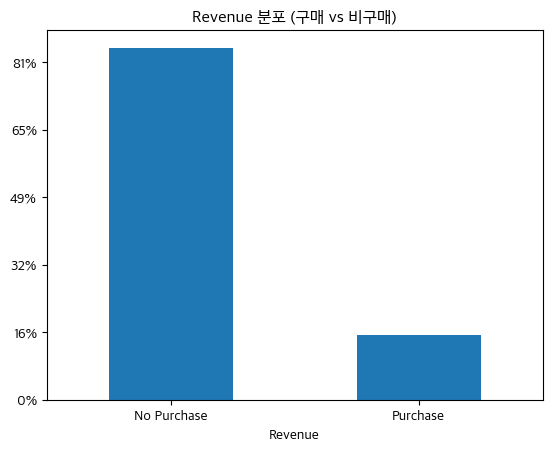

In [2]:
# 결측치 확인
df.isnull().sum()

# 중복 확인
dup_cnt = df.duplicated().sum()
dup_ratio = dup_cnt / len(df) * 100
print(f"중복 행 개수: {dup_cnt} ({dup_ratio:.2f}%)")

# 필요하면 중복 제거 (모델링 전에 고려)
# df = df.drop_duplicates().reset_index(drop=True)

# 타깃 분포 확인
target_col = "Revenue"
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))

import matplotlib.ticker as mtick

fig, ax = plt.subplots()
df[target_col].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(["No Purchase", "Purchase"], rotation=0)
ax.set_title("Revenue 분포 (구매 vs 비구매)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
plt.show()


In [3]:
# 수치형 / 범주형 분리
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("수치형 변수:", num_cols)
print("범주형 변수:", cat_cols)

# 기술 통계
display(df[num_cols].describe().T)


수치형 변수: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
범주형 변수: ['Month', 'VisitorType', 'Weekend', 'Revenue']


,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000



=== Month 분포 ===


Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64

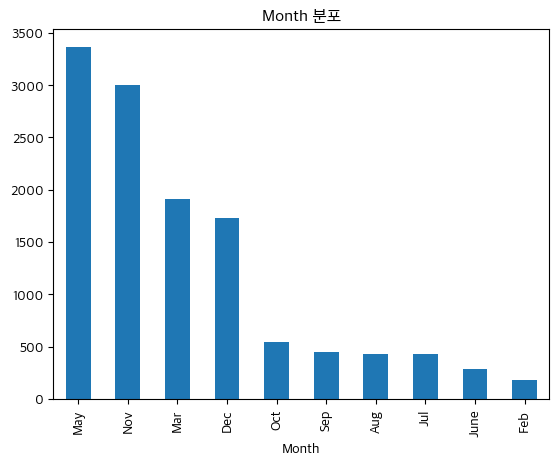


=== VisitorType 분포 ===


VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

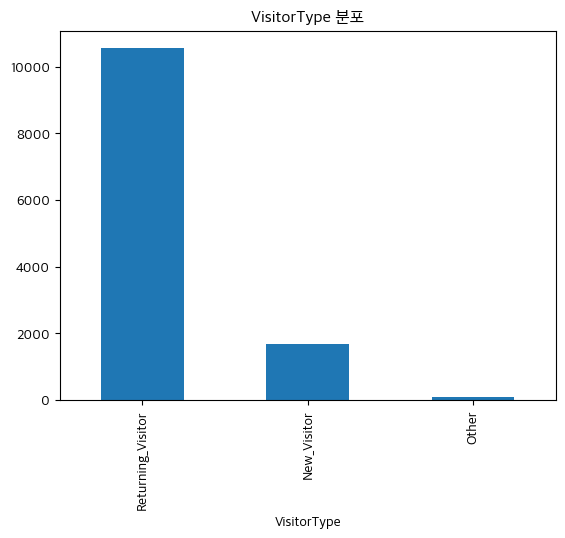


=== Weekend 분포 ===


Weekend
False    9462
True     2868
Name: count, dtype: int64

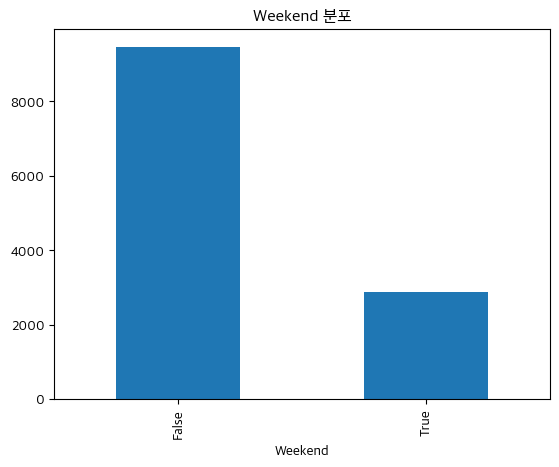

In [4]:
# 주요 범주형 변수 분포
for col in ["Month", "VisitorType", "Weekend"]:
    print(f"\n=== {col} 분포 ===")
    display(df[col].value_counts())
    df[col].value_counts().plot(kind="bar")
    plt.title(f"{col} 분포")
    plt.show()


In [5]:
# 이상치 탐지 (특히 체류시간/페이지 뷰/페이지 가치)
def iqr_outlier_ratio(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    mask = (s < lb) | (s > ub)
    return mask.mean() * 100, lb, ub

outlier_summary = []
for col in num_cols:
    # 명백한 코드형 변수는 제외
    if col in ["OperatingSystems", "Browser", "Region", "TrafficType"]:
        continue
    ratio, lb, ub = iqr_outlier_ratio(df[col])
    outlier_summary.append({
        "col": col,
        "outlier_ratio(%)": round(ratio, 2),
        "lower_bound": round(lb, 2),
        "upper_bound": round(ub, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values("outlier_ratio(%)", ascending=False)
display(outlier_df)


,col,outlier_ratio(%),lower_bound,upper_bound
8,PageValues,22.14,0.00,0.00
2,Informational,21.34,0.00,0.00
3,Informational_Duration,19.51,0.00,0.00
6,BounceRates,12.58,-0.03,0.04
9,SpecialDay,10.15,0.00,0.00
1,Administrative_Duration,9.51,-139.88,233.14
7,ExitRates,8.91,-0.04,0.10
4,ProductRelated,8.00,-39.50,84.50
5,ProductRelated_Duration,7.79,-1735.89,3384.19
0,Administrative,3.28,-6.00,10.00


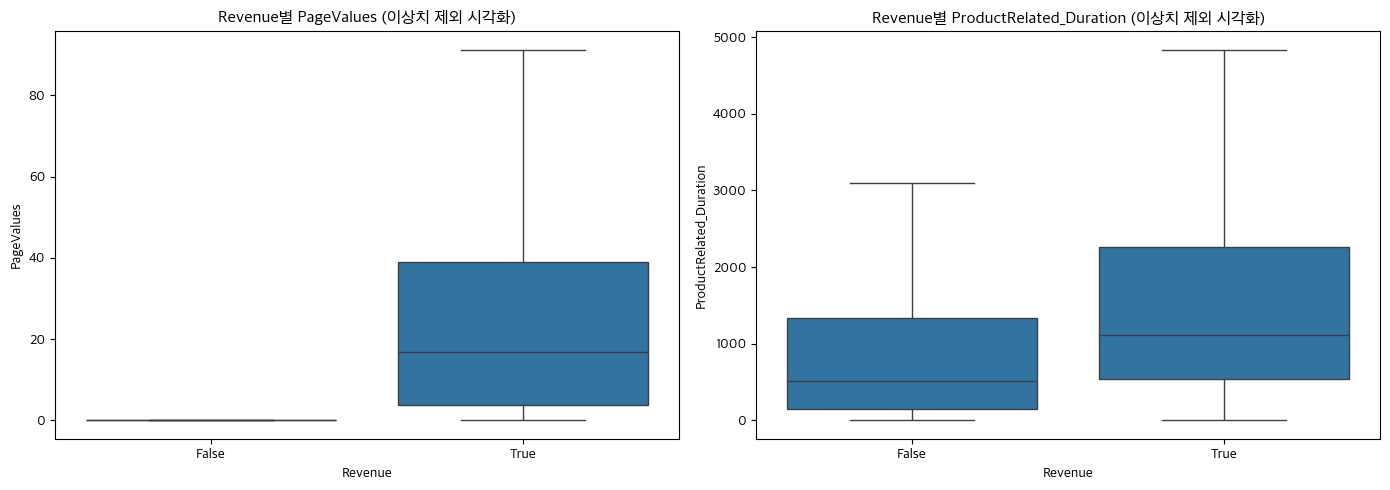

In [6]:
# 예시: PageValues, ProductRelated_Duration 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x="Revenue", y="PageValues", data=df, showfliers=False, ax=axes[0])
axes[0].set_title("Revenue별 PageValues (이상치 제외 시각화)")
sns.boxplot(x="Revenue", y="ProductRelated_Duration", data=df, showfliers=False, ax=axes[1])
axes[1].set_title("Revenue별 ProductRelated_Duration (이상치 제외 시각화)")
plt.tight_layout()
plt.show()


In [7]:
# 주요 수치형 지표 평균 비교
key_cols = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues"
]

rev_group = df.groupby("Revenue")[key_cols].mean().T
rev_group.columns = ["No Purchase", "Purchase"]
display(rev_group)


,No Purchase,Purchase
Administrative,2.117732,3.393606
Administrative_Duration,73.740111,119.483244
Informational,0.451833,0.786164
Informational_Duration,30.236237,57.611427
ProductRelated,28.714642,48.210168
ProductRelated_Duration,1069.987809,1876.209615
BounceRates,0.025317,0.005117
ExitRates,0.047378,0.019555
PageValues,1.975998,27.264518


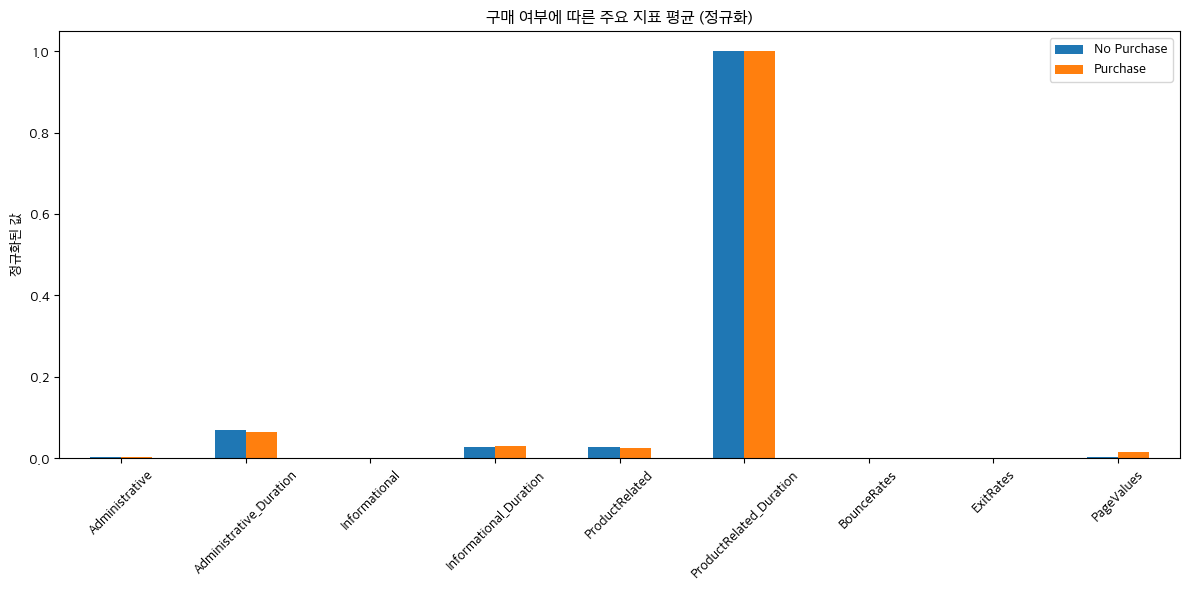

In [8]:
# 시각화: 스케일이 많이 다른 변수는 정규화해서 비교
rev_group_norm = (rev_group - rev_group.min()) / (rev_group.max() - rev_group.min())

rev_group_norm.plot(kind="bar", figsize=(12, 6))
plt.title("구매 여부에 따른 주요 지표 평균 (정규화)")
plt.ylabel("정규화된 값")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


PageValues = 0:
Revenue
False    96.145833
True      3.854167
Name: proportion, dtype: float64

PageValues > 0:
Revenue
True     56.336996
False    43.663004
Name: proportion, dtype: float64


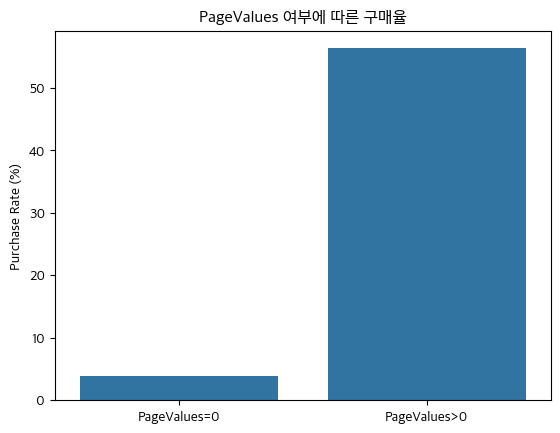

In [9]:
# PageValues의 임팩트
cond_zero = df["PageValues"] == 0
pv_zero = df[cond_zero]["Revenue"].value_counts(normalize=True) * 100
pv_nonzero = df[~cond_zero]["Revenue"].value_counts(normalize=True) * 100

print("PageValues = 0:")
print(pv_zero)
print("\nPageValues > 0:")
print(pv_nonzero)

sns.barplot(x=["PageValues=0", "PageValues>0"],
            y=[pv_zero.get(True, 0), pv_nonzero.get(True, 0)])
plt.ylabel("Purchase Rate (%)")
plt.title("PageValues 여부에 따른 구매율")
plt.show()


In [10]:
# Revenue와의 상관관계 (Point-Biserial)
df["Revenue_int"] = df["Revenue"].astype(int)

corr_list = []
for col in key_cols:
    r, p = stats.pointbiserialr(df["Revenue_int"], df[col])
    corr_list.append({"col": col, "r": r, "p": p})

corr_df = pd.DataFrame(corr_list).sort_values("r", ascending=False)
display(corr_df)


,col,r,p
8,PageValues,0.492569,0.000000e+00
4,ProductRelated,0.158538,3.241187e-70
5,ProductRelated_Duration,0.152373,6.115338e-65
0,Administrative,0.138917,3.519760e-54
2,Informational,0.095200,3.174034e-26
1,Administrative_Duration,0.093587,2.146514e-25
3,Informational_Duration,0.070345,5.282871e-15
6,BounceRates,-0.150673,1.594198e-63
7,ExitRates,-0.207071,1.662654e-119


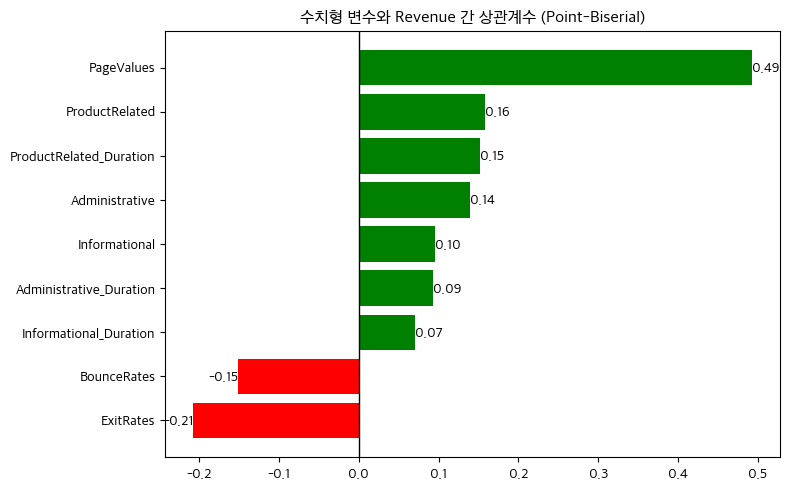

In [11]:
# 시각화: 상관계수 막대 그래프
fig, ax = plt.subplots(figsize=(8, 5))
corr_sorted = corr_df.sort_values("r", ascending=True)
colors = ["red" if r < 0 else "green" for r in corr_sorted["r"]]
ax.barh(corr_sorted["col"], corr_sorted["r"], color=colors)
ax.axvline(0, color="black", linewidth=1)
for i, v in enumerate(corr_sorted["r"]):
    ax.text(v, i, f"{v:.2f}", va="center",
            ha="left" if v > 0 else "right")
ax.set_title("수치형 변수와 Revenue 간 상관계수 (Point-Biserial)")
plt.tight_layout()
plt.show()


Revenue,False,True
Bounce_bin,,
0-1%,78.094871,21.905129
1-5%,90.113676,9.886324
5-10%,97.400000,2.600000
10-20%,99.509804,0.490196


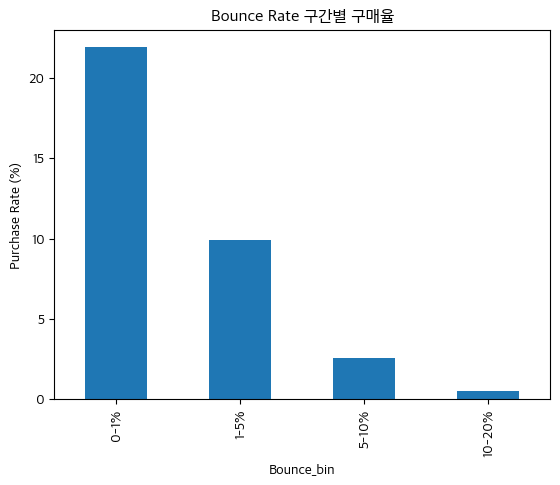

Revenue,False,True
Exit_bin,,
0-2.5%,76.783655,23.216345
2.5-5%,88.562092,11.437908
5-10%,95.664909,4.335091
10-20%,99.460432,0.539568


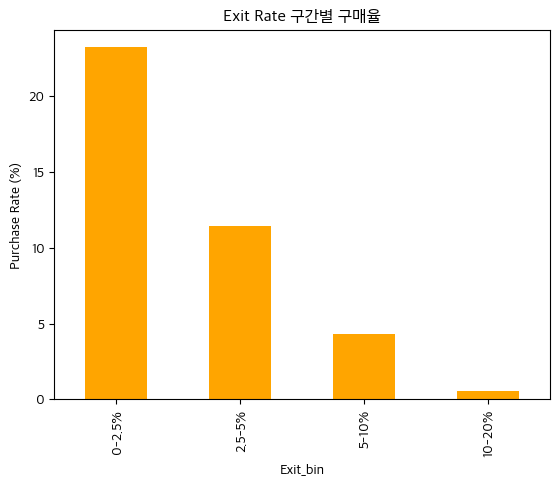

In [12]:
# 구간별 구매 전환율
# BounceRate 구간화
df["Bounce_bin"] = pd.cut(
    df["BounceRates"],
    bins=[0, 0.01, 0.05, 0.1, 0.2],
    labels=["0-1%", "1-5%", "5-10%", "10-20%"]
)
bounce_tab = pd.crosstab(df["Bounce_bin"], df["Revenue"], normalize="index") * 100
display(bounce_tab)

bounce_tab[True].plot(kind="bar")
plt.ylabel("Purchase Rate (%)")
plt.title("Bounce Rate 구간별 구매율")
plt.show()

# ExitRate 구간화
df["Exit_bin"] = pd.cut(
    df["ExitRates"],
    bins=[0, 0.025, 0.05, 0.1, 0.2],
    labels=["0-2.5%", "2.5-5%", "5-10%", "10-20%"]
)
exit_tab = pd.crosstab(df["Exit_bin"], df["Revenue"], normalize="index") * 100
display(exit_tab)

exit_tab[True].plot(kind="bar", color="orange")
plt.ylabel("Purchase Rate (%)")
plt.title("Exit Rate 구간별 구매율")
plt.show()


Revenue
False    1173.964158
True     2053.304285
Name: TotalDuration, dtype: float64


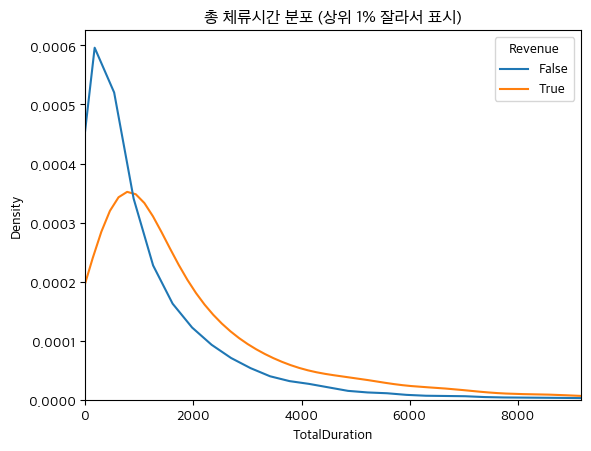

In [13]:
# 체류시간(총 Duration)과 이탈
df["TotalDuration"] = (
    df["Administrative_Duration"] +
    df["Informational_Duration"] +
    df["ProductRelated_Duration"]
)

print(df.groupby("Revenue")["TotalDuration"].mean())

sns.kdeplot(data=df, x="TotalDuration", hue="Revenue", common_norm=False)
plt.xlim(0, df["TotalDuration"].quantile(0.99))  # 꼬리 잘라내기
plt.title("총 체류시간 분포 (상위 1% 잘라서 표시)")
plt.show()


Revenue,No_Purchase,Purchase
Month,,
Aug,82.448037,17.551963
Dec,87.492762,12.507238
Feb,98.369565,1.630435
Jul,84.722222,15.277778
June,89.930556,10.069444
Mar,89.931830,10.068170
May,89.149822,10.850178
Nov,74.649767,25.350233
Oct,79.052823,20.947177


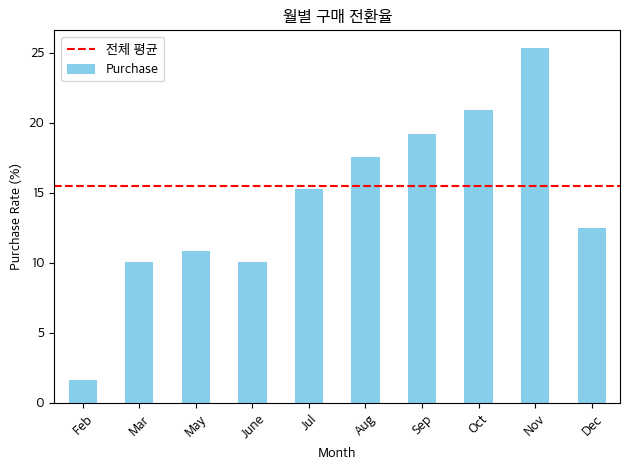

In [14]:
# 월별 전환율(시즌성 / 프로모션 영향)
month_conv = pd.crosstab(df["Month"], df["Revenue"], normalize="index") * 100
month_conv = month_conv.rename(columns={False: "No_Purchase", True: "Purchase"})
display(month_conv.sort_index())

# 월 순서 정의
order = ["Feb", "Mar", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_conv_ord = month_conv.reindex(order)

month_conv_ord["Purchase"].plot(kind="bar", color="skyblue")
plt.ylabel("Purchase Rate (%)")
plt.title("월별 구매 전환율")
plt.xticks(rotation=45)
plt.axhline(df["Revenue"].mean() * 100, color="red", linestyle="--", label="전체 평균")
plt.legend()
plt.tight_layout()
plt.show()


Revenue,No_Purchase,Purchase
VisitorType,,
New_Visitor,75.088548,24.911452
Other,81.176471,18.823529
Returning_Visitor,86.067671,13.932329


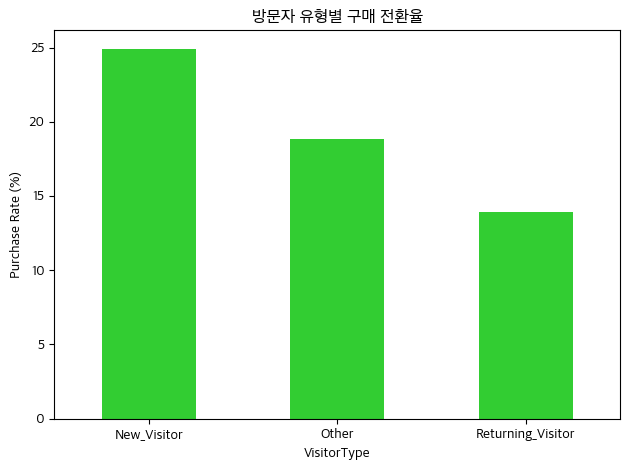

In [15]:
# 방문자 유형별 전환율
visitor_conv = pd.crosstab(df["VisitorType"], df["Revenue"], normalize="index") * 100
visitor_conv = visitor_conv.rename(columns={False: "No_Purchase", True: "Purchase"})
display(visitor_conv)

visitor_conv["Purchase"].sort_values(ascending=False).plot(kind="bar", color="limegreen")
plt.ylabel("Purchase Rate (%)")
plt.title("방문자 유형별 구매 전환율")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Revenue,False,True
Weekend,,
Weekday,85.108856,14.891144
Weekend,82.601116,17.398884


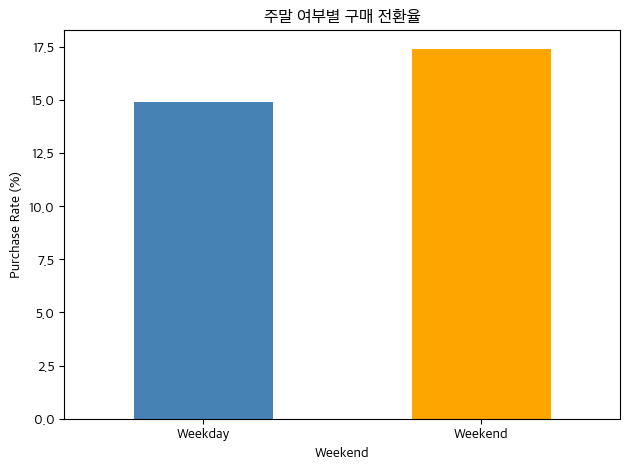

In [16]:
weekend_conv = pd.crosstab(df["Weekend"], df["Revenue"], normalize="index") * 100
weekend_conv = weekend_conv.rename(index={False: "Weekday", True: "Weekend"})
display(weekend_conv)

weekend_conv[True].plot(kind="bar", color=["steelblue", "orange"])
plt.ylabel("Purchase Rate (%)")
plt.title("주말 여부별 구매 전환율")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
